In [1]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
# from pattern.es import lemma
from nltk.stem import WordNetLemmatizer

# from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(15,5)

import joblib
from tqdm import tqdm, tqdm_notebook

from statistics import mean
import re
# nltk.download('punkt')
import unicodedata
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from spellchecker import SpellChecker
import emoji
import textstat
from wordcloud import WordCloud

from sklearn.metrics import classification_report

In [2]:
psy=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube01-Psy.csv")
kp=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube02-KatyPerry.csv")
lmfao=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube03-LMFAO.csv")
eminem=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube04-Eminem.csv")
shakira=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube05-Shakira.csv")

data=pd.concat([psy,kp,lmfao,eminem,shakira],axis=0,ignore_index=True)
data.to_csv('JoinedTrainingData.csv')
print('This is training data\'s shape :',data.shape)

This is training data's shape : (1956, 5)


###  Feature Engineering: 


Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

#### Length of comments

In [3]:
# data['CommentLength']=data['CONTENT'].apply(len)
# data.head(2)


####  % of UpperCase letters

In [4]:
# Function to count capital letters
def countCaps(comment):
    count=0
    for c in comment:
        if c.isupper():
            count+=1
    return round(count*100/len(comment),2)
        
        

data['%OfUpperCaseLetters']=data['CONTENT'].apply(countCaps)
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,%OfUpperCaseLetters
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,1.79
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,12.05


####  Find no. of URLs in comments

In [5]:
pattern='(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'

data['NoOfURL']=data['CONTENT'].apply(lambda x: len(re.findall(pattern,x)))

####  Avg length of each word

In [6]:
def AvgLengthOfEachWord(comment):
    return(round(mean([len(c) for c in comment.split(' ')]),2))

data['AvgLengthOfEachWord']=data['CONTENT'].apply(AvgLengthOfEachWord)

#### No. of stop words in each comment

In [7]:
def NoOfStopWords(comment):
    count=0
    for word in comment:
        if word in stopwords.words('english'):
            count+=1
    return round(count*100/len(comment),2)

data['%OfNoOfStopWords']=data['CONTENT'].apply(NoOfStopWords)

####  No. of sentences in each review

In [8]:
# def NoOfSentences(comment):
#     return(len(sent_tokenize(comment)))

# data['NoOfSentences']=data['CONTENT'].apply(NoOfSentences)

#### No. of words in each review

In [9]:
def NoOfWords(comment):
    return(len(word_tokenize(comment)))

data['NoOfWords']=data['CONTENT'].apply(NoOfWords)

####  No. of unique words

In [10]:
def NoOfUniqueWords(comment):
    
    return(len(set(word_tokenize(comment)))/len(word_tokenize(comment)))

data['%OfNoOfUniqueWords']=data['CONTENT'].apply(NoOfUniqueWords)

In [11]:
data.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS',
       '%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       '%OfNoOfStopWords', 'NoOfWords', '%OfNoOfUniqueWords'],
      dtype='object')

####  Add features for readability, complexity and grade level (using Textstat library)

In [12]:
data['AvgSentenceLength']=data['CONTENT'].apply(lambda x: textstat.avg_sentence_length(x))

In [13]:
# data['FleschReadingEase']=data['CONTENT'].apply(lambda x: textstat.flesch_reading_ease(x))

# data['GunningFog']=data['CONTENT'].apply(lambda x: textstat.gunning_fog(x))

# data['SmogIndex']=data['CONTENT'].apply(lambda x: textstat.smog_index(x))

# data['ARI']=data['CONTENT'].apply(lambda x: textstat.automated_readability_index(x))

# data['ColemanLiauIndex']=data['CONTENT'].apply(lambda x: textstat.coleman_liau_index(x))

In [14]:
data['TextStandard']=data['CONTENT'].apply(lambda x: textstat.text_standard(x,float_output=True))
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,%OfNoOfStopWords,NoOfWords,%OfNoOfUniqueWords,AvgSentenceLength,TextStandard
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,1.79,0,6.12,32.14,13,1.000,8.0,3.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,12.05,0,4.22,26.51,40,0.775,15.0,6.0


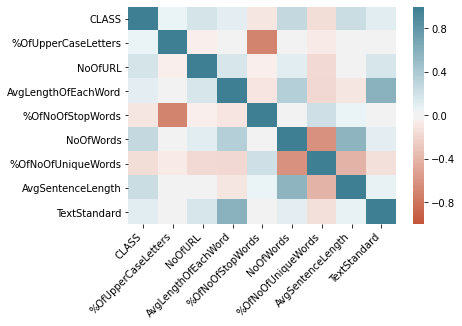

In [15]:
corr=data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Clean-up comments

In [16]:
# lemmatize as per part of speech of the word
# It may not be possible manually provide the corrent POS tag for every word for large texts.
# So, instead, we will find out the correct POS tag for each word, map it to the right input character
# that the WordnetLemmatizer accepts and pass it as the second argument to lemmatize().

def lemmatize(cleanTextList):
    
#     Create a dictionary to map POS
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
#     tag part of speech for each word
    pos_tagged_text = nltk.pos_tag(cleanTextList)
    lemmatizer=WordNetLemmatizer()
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [17]:
def correct_spellings(wordList):
    spell = SpellChecker()
    corrected_text = []
    
    # find those words that may be misspelled
    misspelled = spell.unknown(wordList.split())
    
    for word in wordList.split():
        if word in misspelled:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)


In [18]:
correct_spellings('youtube')

'couture'

List of cleaning items:
- Remove URLs
- Remove html tags
- Remove Emojis
- Convert to lower case
- Remove non-english characters
- Replace all the digits with 9
- Remove stop-words
- Remove punctuations 
- Replace ascent characters
- Lemmatize words
- Correct spelling mistakes


In [20]:
def cleanComment(comment):
    try:
    #   Remove URLS
        pattern1='https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}'        
        comment=re.sub(pattern1,' ',comment)
        
    #   Remove html tags
        comment=re.sub('<[^<]+?>', '', comment)
        
    #   Remove \ufeff    
        comment=comment.replace(u'\ufeff', '')
        
    #   Replace Emojis with text
        comment=emoji.demojize(comment, delimiters=("", ""))
        
    #   turn to lowercase
        comment=comment.lower()
        
    #   Replace digits with 9s
        comment=re.sub(r'\d','9',comment)
        
    #   Remove non-english words
    #   Reference:https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
        comment = re.sub("([^\x00-\x7F])+"," ",comment)

    #   Tokenize to words
        wordList=word_tokenize(comment)

    #   Remove english stopwords
        wordList=[word for word in wordList if word not in stopwords.words('english')]

    #   Remove punctuations
        wordList=[word for word in wordList if word not in string.punctuation]

    #   Convert ascent characters to their normal english characters
    #   Reference: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
        cleanedTextList=[unicodedata.normalize('NFKD',word).encode('ascii', 'ignore').decode('utf-8', 'ignore') \
                  for word in wordList]
        
    #   Lemmatize
        lemmatizedText=lemmatize(cleanedTextList)

    #   Spell Correction
    #   correctedText=correct_spellings(lemmatizedText)

        return lemmatizedText
    except:
        print(comment)
            

In [21]:
tqdm_notebook().pandas()
data['CleanWordList']=data['CONTENT'].progress_apply(lambda x: cleanComment(x));

In [22]:
# Drop rows with no comment 
data.dropna(subset=['CleanWordList'],inplace=True)
data.shape

(1956, 14)

In [23]:
data.to_csv('Data/cleanedData.csv',index=False)

In [24]:
data=pd.read_csv('Data/cleanedData.csv')
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,%OfNoOfStopWords,NoOfWords,%OfNoOfUniqueWords,AvgSentenceLength,TextStandard,CleanWordList
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,1.79,0,6.12,32.14,13,1.000,8.0,3.0,huh anyway check tube channel kobyoshi99
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,12.05,0,4.22,26.51,40,0.775,15.0,6.0,hey guy check new channel first vid u monkey '...


In [25]:
data.dropna(subset=['CleanWordList'],inplace=True)
data.shape

(1898, 14)